## [ISIC 2024 - Skin Cancer Detection with 3D-TBP](https://www.kaggle.com/competitions/isic-2024-challenge/overview)
##### Lingfeng (Ling) Su, Manal Amarsaikhan, Yuxin (Katy) Chen, Keelan Gan

In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import os
from tensorflow.keras import layers, models



#### Dataset Summary Statistics

In [4]:
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)

print("---------------------------------------Shape-------------------------------------------------")
print(metadata.shape)
print("---------------------------------------Info--------------------------------------------------")
print(metadata.info())
print("---------------------------------------Describe----------------------------------------------")
print(metadata.describe())
print("---------------------------------------Missing Data------------------------------------------")
print(metadata.isnull().sum())

---------------------------------------Shape-------------------------------------------------
(401059, 55)
---------------------------------------Info--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A               

#### Class Distribution Before Processing

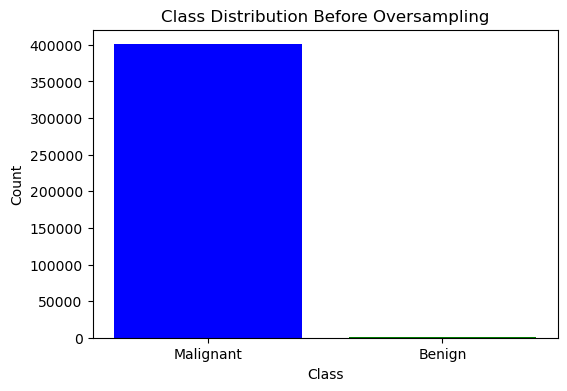

In [5]:
# Count class instances before oversampling
class_counts = metadata['target'].value_counts()

# Plot class distribution before oversampling
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.xticks([0, 1], ['Malignant', 'Benign'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

In [6]:
# Define numerical columns for outlier detection
numeric_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM', 'tbp_lv_deltaLBnorm',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max',
    'tbp_lv_symm_2axis'
]

# Compute Z-scores
z_scores = np.abs(stats.zscore(metadata[numeric_cols]))

# Set threshold (e.g., values greater than 3 std deviations)
threshold = 3
outliers_zscore = metadata[(z_scores > threshold).any(axis=1)]

print(f"Number of outliers detected using Z-Score: {len(outliers_zscore)}")

Number of outliers detected using Z-Score: 28234


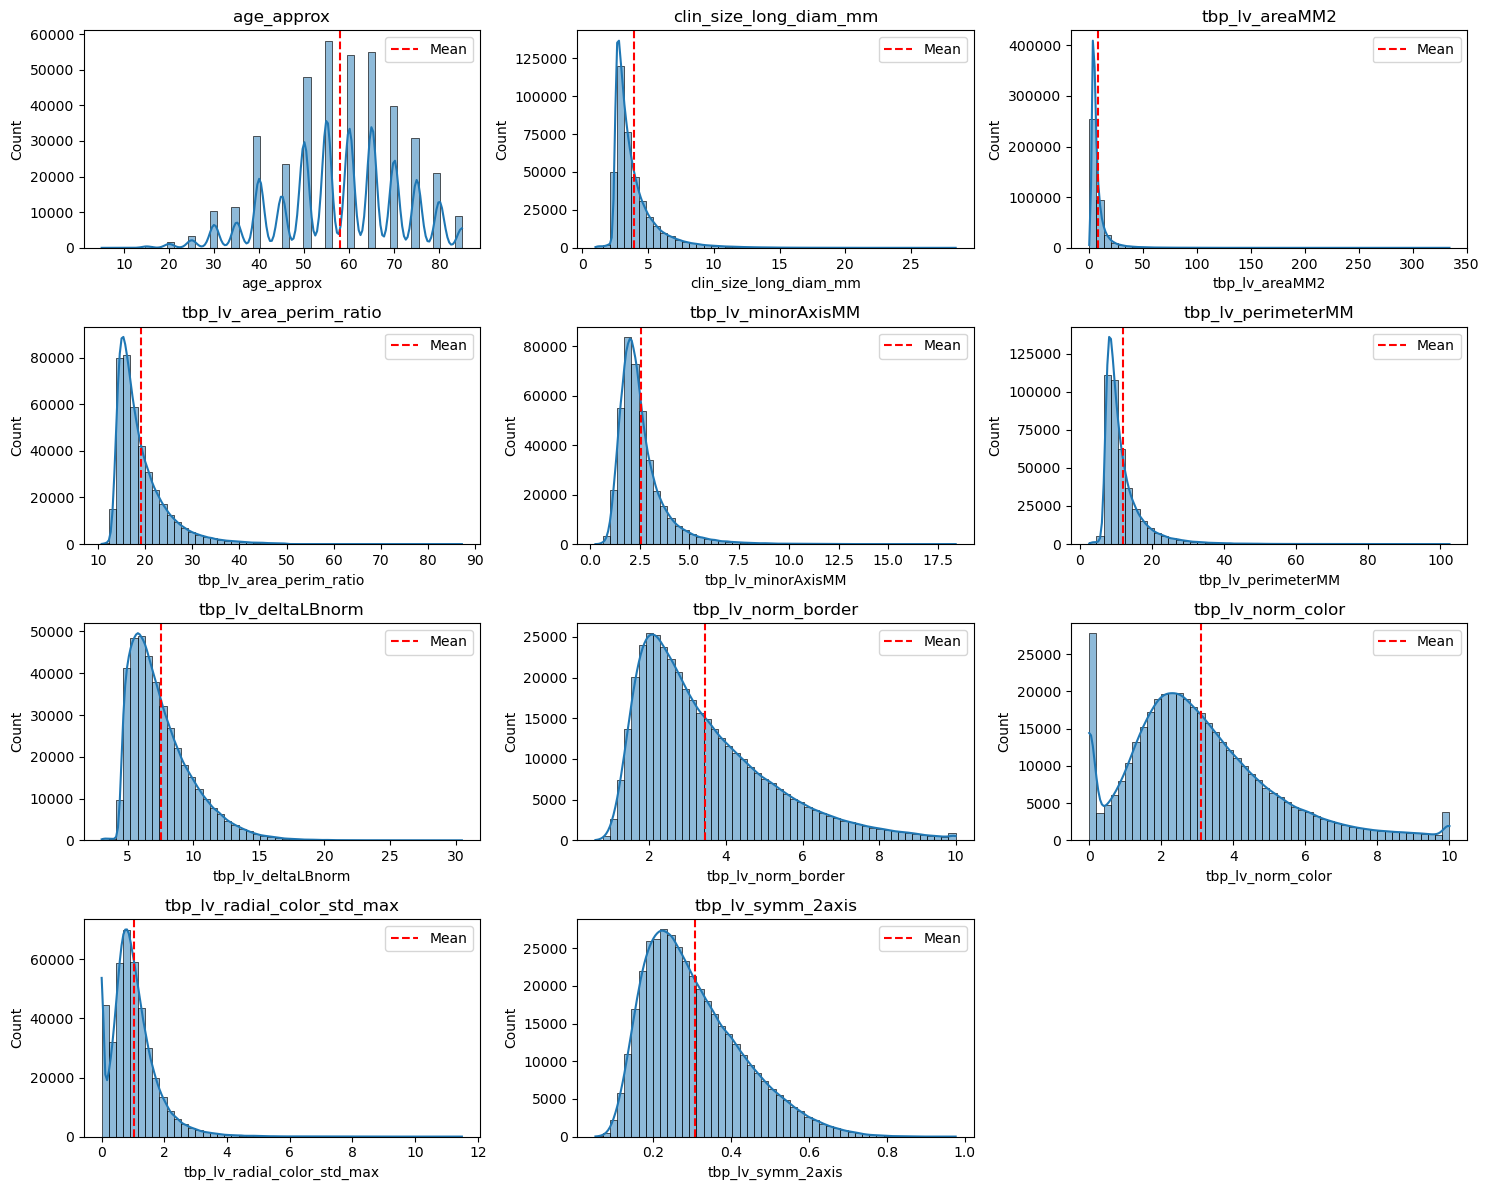

In [7]:
# Plot histograms for all selected numerical features
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)  # Adjust layout based on the number of features
    sns.histplot(metadata[col], bins=50, kde=True)
    plt.axvline(metadata[col].mean(), color='red', linestyle='dashed', label='Mean')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

#### Process Metadata

1. **Removed Unnecessary Columns**:
   - Dropped columns that are only relevant to training data or contain redundant information.
   - Columns removed: `lesion_id`, `iddx_2`, `iddx_3`, `iddx_4`, `iddx_5`, `mel_mitotic_index`, `mel_thick_mm`, `patient_id`, `image_type`, `tbp_tile_type`, `attribution`, `copyright_license`, `tbp_lv_dnn_lesion_confidence`, `iddx_1`, `iddx_full`.
        - `lesion_id`: Unique identifier with no predictive value.
        - `iddx_2`, `iddx_3`, `iddx_4`, `iddx_5`: Redundant or overly granular diagnostic classifications.
        - `mel_mitotic_index`, `mel_thick_mm`: Melanoma-specific features that may introduce bias.
        - `patient_id`: Unique identifier with no predictive value.
        - `image_type`, `tbp_tile_type`: Image normalization will be perfromed later.
        - `attribution`, `copyright_license`: Metadata related to image sourcing, not useful for prediction.
        - `tbp_lv_dnn_lesion_confidence`, `iddx_1`, `iddx_full`: These features are useful, but the safest approach is to train the model without these features, ensuring consistency between train and test datasets.
2. **Handled Missing Values**:
   - Removed rows with missing values in critical columns: `age_approx`, `anatom_site_general`, `sex`.
   - Ensured the dataset is complete and ready for further processing.

3. **Handled outliers**: For our dataset, we will handle outliers based on their impact and biological validity. 
    - Outliers in patient age (`age_approx`) are filtered if they are below 5 or above 100, as they are likely errors. 
    - For lesion size-related features (`clin_size_long_diam_mm`, `tbp_lv_areaMM2`, `tbp_lv_minorAxisMM`, `tbp_lv_perimeterMM`), we remove implausible values and apply Winsorization to cap extreme values at the 1st and 99th percentiles. 
    - Features related to lesion border irregularity, color variation, and asymmetry (`tbp_lv_norm_border`, `tbp_lv_norm_color`, `tbp_lv_radial_color_std_max`, `tbp_lv_symm_2axis`) may contain valuable diagnostic information, so instead of removing outliers, we apply Robust Scaling to reduce their influence. This approach ensures we retain meaningful patterns in the data while reducing the impact of extreme values.

3. **Separated Minority and Majority Classes**:
   - Split the dataset into minority class (`target = 1`) and majority class (`target = 0`).

4. **Shuffled the Dataset**:
   - Shuffled the dataset to ensure randomness and avoid bias during training. 

#### Key Insights
- The dataset will utilize class weights during model training to address the class imbalance, ensuring the model appropriately prioritizes the minority class.
- Irrelevant columns and missing values have been removed, ensuring data quality.
- The dataset is ready for further preprocessing and model training.

In [8]:
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)
# removed some columns included only in training data
metadata = metadata.drop(columns=['lesion_id', 'iddx_2', 'iddx_3','iddx_4','iddx_5','mel_mitotic_index','mel_thick_mm','tbp_lv_dnn_lesion_confidence', 'iddx_1', 'iddx_full'])
metadata = metadata.drop(columns=['patient_id','image_type','tbp_tile_type','attribution','copyright_license'])
# filter out data with missing values
metadata = metadata.dropna(subset=['age_approx', 'anatom_site_general', 'sex'])


# Define filtering thresholds for biologically implausible values
metadata = metadata[
    (metadata['age_approx'] >= 5) & (metadata['age_approx'] <= 100)
]
# Apply Winsorization to cap extreme values for lesion size-related features
size_cols = ['clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM']
for col in size_cols:
    metadata[col] = winsorize(metadata[col], limits=[0.01, 0.01])  # Cap at 1st and 99th percentile
# Apply RobustScaler to features where outliers may be informative
scale_cols = ['tbp_lv_area_perim_ratio', 'tbp_lv_deltaLBnorm', 'tbp_lv_norm_border', 
              'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max', 'tbp_lv_symm_2axis']
scaler = RobustScaler()
metadata[scale_cols] = scaler.fit_transform(metadata[scale_cols])

metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

#### Class Distribution After Processing

In [9]:
metadata.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,ISIC_7147422,0,40.0,female,posterior torso,3.00,24.029030,15.282590,44.048500,38.096760,...,0.383237,8.806065,-0.065106,3.674487,1.845194,-0.630193,30,-137.097800,1211.183000,144.318500
1,ISIC_1507281,0,65.0,male,upper extremity,3.55,16.568480,12.960110,24.118800,22.425760,...,0.305883,11.438010,0.541378,2.339820,1.597620,0.077003,0,-422.920200,1055.631000,19.795900
2,ISIC_6058560,0,60.0,male,lower extremity,6.37,13.028916,9.645184,23.861454,22.091742,...,-0.107049,19.936864,-0.216367,1.610065,1.640676,2.257810,85,208.417053,176.819626,84.927002
3,ISIC_1546058,0,55.0,female,lower extremity,6.99,15.376774,9.929800,25.938329,23.483679,...,1.456297,19.422157,1.250416,3.880231,2.199233,1.093100,120,220.242371,528.426453,10.920227
4,ISIC_3158974,0,70.0,female,lower extremity,5.21,20.070527,17.066881,24.714661,23.299075,...,-0.310480,18.647245,-1.142689,1.590689,2.857723,2.214430,155,120.173080,446.146454,28.172852


#### Image Sample With Properties

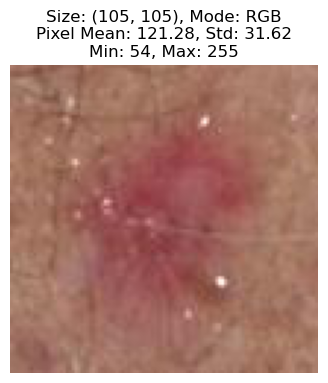

In [10]:
sample_image_path = r"isic-2024-challenge\train-image\image\ISIC_9996602.jpg"
img = Image.open(sample_image_path)

# Get image properties
image_size = img.size
image_mode = img.mode

# Convert image to numpy array for pixel statistics
img_array = np.array(img)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Data Preprocessing Steps

##### 1. **Mapping Image Filenames to Labels**
- **Step**: Create a mapping from image filenames to labels using a dictionary.
- **Transformation**:
  - Append `.jpg` to `isic_id` to match image filenames.
  - Example: `isic_id = '12345'` → `'12345.jpg'`.
- **Purpose**: Align image filenames with their corresponding labels for further processing.

##### 2. **Splitting the Dataset**
- **Step**: Split the dataset into training (80%) and testing (20%) sets.
- **Transformation**:
  - Split minority and majority classes separately to maintain class distribution.
  - Use `train_test_split` with `test_size=0.2` and `random_state=42`.
- **Purpose**: Ensure the model is evaluated on a representative subset of the data.

##### 3. **Handling Class Imbalance**
- **Step**: Oversample the minority train class (`target = 1`) to address imbalance.
- **Transformation**:
  - Use `image_multiplier` to generate 30 augmented images per minority train class image.
  - Save augmented images in `processed_dir`.
  - Assign labels `1` to augmented images.
- **Purpose**: Balance the train dataset to prevent model bias toward the majority class.
- **Feature Engineering**:
  - Augmentation includes transformations like rotation, or scaling.

##### 4. **Creating TensorFlow Datasets**
- **Step**: Create TensorFlow datasets for training and testing sets.
- **Transformation**:
  - Use `tf.data.Dataset.from_tensor_slices` to create datasets from image paths and labels.
- **Purpose**: Enable efficient loading and preprocessing of data.

##### 5. **Parallelizing Image Loading and Preprocessing**
- **Step**: Apply `load_and_preprocess_image` to each image.
- **Transformation**:
  - Steps likely include:
    1. **Loading**: Load image from file path.
    2. **Resizing**: Resize to a consistent size (e.g., 100x100 pixels).
    3. **Normalization**: Normalize pixel values to [0, 1] or [-1, 1].
  - Use `map` with `num_parallel_calls=tf.data.experimental.AUTOTUNE` for parallel processing.
- **Purpose**: Ensure images are in a suitable format for training and improve processing speed.

##### 6. **Batching the Dataset**
- **Step**: Batch the dataset with a size of 1000.
- **Transformation**:
  - Majority class constitutes 90% of each batch; minority class constitutes 10%.
  - Use `repeat` to allow multiple iterations during training.
- **Purpose**: Improve computational efficiency by processing multiple images at once.

##### 7. **Combining Minority and Majority Class Batches**
- **Step**: Combine minority and majority class batches into a single dataset.
- **Transformation**:
  - Use `tf.data.Dataset.zip` to combine datasets.
  - Use `map` to concatenate images and labels from both classes.
- **Purpose**: Ensure each batch contains a balanced mix of minority and majority class samples.


#### Summary of Key Preprocessing Steps

| **Step**                          | **Description**                                                                 |
|------------------------------------|---------------------------------------------------------------------------------|
| **Mapping Filenames to Labels**    | Align image filenames with labels.                                              |
| **Splitting the Dataset**          | Split into training and testing sets while maintaining class balance.            |
| **Handling Class Imbalance**       | Oversample minority class using data augmentation.                              |
| **Creating TensorFlow Datasets**   | Create efficient datasets for loading and preprocessing.                        |
| **Parallelizing Preprocessing**    | Apply image loading and preprocessing in parallel.                              |
| **Batching**                       | Combine minority and majority class samples into balanced batches.              |

In [11]:
def load_and_preprocess_image(image_path, label):
    width, height = 100, 100
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    image = tf.image.resize(image, [width, height])
    image = image / 255.0
    
    return image, label

In [12]:
def image_multiplier(path, name, img, n):
    images = []
    for _ in range(n):
        tmp = img.copy()
        
        # random rotation
        angle = random.choice([90, 180, 270])
        tmp = tmp.rotate(angle, expand = True)
        
        # random brightness, contrast, and color
        brightness = random.uniform(0.8, 1.2)
        contrast = random.uniform(1, 1.2)
        color = random.uniform(1, 1.5)
        tmp = ImageEnhance.Brightness(tmp).enhance(brightness)
        tmp = ImageEnhance.Contrast(tmp).enhance(contrast)
        tmp = ImageEnhance.Color(tmp).enhance(color)
        
        # random orientation
        c = random.choice(['none', 'mirror', 'flip', 'mirror_flip'])
        if c == 'mirror':
            tmp = ImageOps.mirror(tmp)
        elif c == 'flip':
            tmp = ImageOps.flip(tmp)
        elif c == 'mirror_flip':
            tmp = ImageOps.mirror(tmp)
            tmp = ImageOps.flip(tmp)
            
        # random shear 
        #shear = random.uniform(-0.5, 0.5)
        #tmp = tmp.transform(tmp.size, Image.AFFINE, (1, shear, 0, 0, 1, 0))
        #variants.append(tmp)

        # random zoom
        scale = random.uniform(0.6, 1.5)
        tmpsize = (int(tmp.width * scale), int(tmp.height * scale))
        tmp = tmp.resize(tmpsize, Image.BICUBIC)

        # Save the image
        newname = name + str(random.randint(0, n)) + '.jpg'
        newpath = path + '/' + newname
        tmp.save(newpath)
        images.append(newpath)
    return images

In [13]:
# Load metadata
image_dir = r"isic-2024-challenge\train-image\image"
processed_dir = r"isic-2024-challenge\processed_images"

# create DIR for run once use many times
os.makedirs(processed_dir, exist_ok=True)

# Create a mapping from image filenames to labels
labels = metadata[['isic_id', 'target']].copy()
labels['isic_id'] = labels['isic_id'].apply(lambda x: x + '.jpg')
image_to_label = dict(zip(labels['isic_id'], labels['target']))

# Create a list of image file paths and their corresponding labels
image_paths = [os.path.join(image_dir, img_id) for img_id in labels['isic_id']]
image_labels = [image_to_label[img_id] for img_id in labels['isic_id']]
new_labels = pd.DataFrame({'isic_id': image_paths, 'target': image_labels})


# Separate the minority and majority classes
minority_class = new_labels[new_labels['target'] == 1]
majority_class = new_labels[new_labels['target'] == 0]

# Split minority and majority classes into train and test sets (80-20 split)
minority_train, minority_test = train_test_split(minority_class, test_size=0.2, random_state=42)
majority_train, majority_test = train_test_split(majority_class, test_size=0.2, random_state=42)

# Reset indices
minority_train = minority_train.reset_index(drop=True)
minority_test = minority_test.reset_index(drop=True)
majority_train = majority_train.reset_index(drop=True)
majority_test = majority_test.reset_index(drop=True)

# Oversample the minority class
n = 30
for img_id in minority_train['isic_id']:
    img = Image.open(img_id)
    img_name = os.path.basename(img_id).split('.')[0]
    new_images = image_multiplier(processed_dir, img_name, img, n)
    new_labels = [1] * len(new_images)
    minority_class = pd.concat([minority_train, pd.DataFrame({'isic_id': new_images, 'target': new_labels})], ignore_index=True)

# Create TensorFlow datasets for train and test sets
def create_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

# Training datasets
minority_train_dataset = create_dataset(minority_train['isic_id'], minority_train['target'])
majority_train_dataset = create_dataset(majority_train['isic_id'], majority_train['target'])

# Testing datasets
minority_test_dataset = create_dataset(minority_test['isic_id'], minority_test['target'])
majority_test_dataset = create_dataset(majority_test['isic_id'], majority_test['target'])


# Parallelize image loading and preprocessing
minority_train_dataset = minority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_train_dataset = majority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

minority_test_dataset = minority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_test_dataset = majority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the dataset
batch_size = 1000
majority_ratio = 0.9
minority_ratio = 0.1
num_batches = 10

majority_batch_size = int(batch_size * majority_ratio)
minority_batch_size = int(batch_size * minority_ratio)

minority_train_dataset = minority_train_dataset.repeat()
minority_train_dataset = minority_train_dataset.shuffle(buffer_size=1000)
majority_train_dataset = majority_train_dataset.repeat()
majority_train_dataset = majority_train_dataset.shuffle(buffer_size=1000)


minority_train_dataset = minority_train_dataset.batch(minority_batch_size)
majority_train_dataset = majority_train_dataset.batch(majority_batch_size)

# Combine the minority and majority class train Batches
train_dataset = tf.data.Dataset.zip((minority_train_dataset, majority_train_dataset)).map(lambda x, y: (tf.concat([x[0], y[0]], 0), tf.concat([x[1], y[1]], 0)))
# Combine the minority and majority class test datasets
test_dataset = minority_test_dataset.concatenate(majority_test_dataset)

In [14]:
# Print the first batch
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    

Images shape: (1000, 100, 100, 3)
Labels shape: (1000,)


#### Processed image with propertities

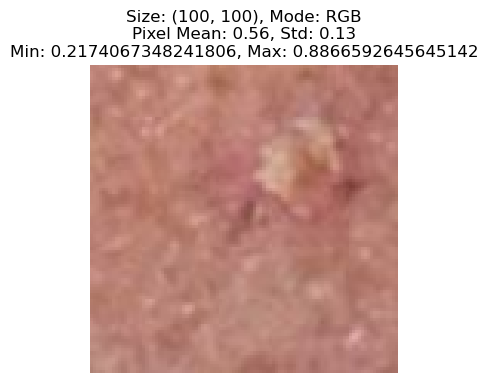

In [15]:
sample_image = images[1].numpy()

# Get image properties
image_size = sample_image.shape[:2]
image_mode = "RGB"

# Convert image to numpy array for pixel statistics
img_array = np.array(sample_image)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Class Distribution per Batch After Processing

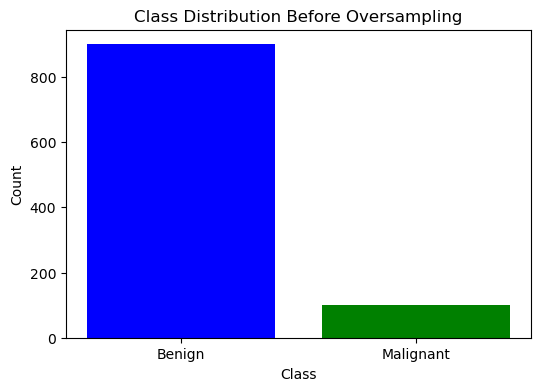

In [16]:
class_counts = np.bincount(labels.numpy())

plt.figure(figsize=(6, 4))
plt.bar([0, 1], class_counts, color=['blue', 'green'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

In [ ]:
X_input = layers.Input((100,100,3))
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X = layers.BatchNormalization()(X)
X_branch1 = X
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch2 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)


X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch3 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch3])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.3)(X)


X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch4 = X
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch4])
X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.4)(X)
X = layers.Dense(2)(X)
X = layers.Softmax()(X)
model_deep_resnet_bn_dropout = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model_resnet_bn_dropout")

model_deep_resnet_bn_dropout.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],)

model_deep_resnet_bn_dropout.summary()

Model: "Deep_CNN_Model_resnet_bn_dropout"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 100, 100,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 100, 100,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 100, 100,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 100, 100,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 50, 50,    │          0 │ add_4[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 50,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 50, 50,    │     18,496 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 50, 50,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 50, 50,    │     36,928 │ batch_normalizat

 Total params: 3,188,074 (12.16 MB)

 Trainable params: 3,185,514 (12.15 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
history_deep_resnet_bn_dropout = model_deep_resnet_bn_dropout.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=5, batch_size=32)

Epoch 1/10


In [ ]:
plt.plot(history_deep_resnet_bn_dropout.history['accuracy'], label='train accuracy')
plt.plot(history_deep_resnet_bn_dropout.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep ResNet w/ Batch Normalization')
plt.legend(); plt.show()

print("Average test accuracy for Deep ResNet w/ Batch Normalization: ", 
      np.round( history_deep_resnet_bn_dropout.history['val_accuracy'][-1], 4) )